In [140]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import scipy.special as sf

In [116]:
dt = 0.2
D = 1.0
L = 41.0
#xl = 5.0
#xr = 6.0
N = 20
length = 1000000

In [117]:
# generate steps for all particles
steps=np.random.normal(loc=0.0, scale=2*D*dt, size=(N,length))

In [118]:
# initial positions
x = L*np.random.random(size=(N,))

In [119]:
# put initial position in front
x = np.column_stack((x, steps))

In [120]:
# calculate paths
paths = np.mod(np.cumsum(x, axis=1),L)

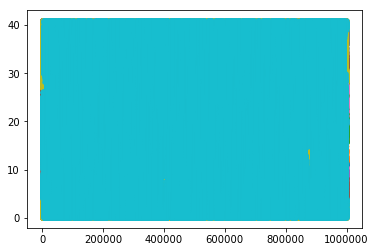

In [121]:
for path in paths:
    plt.plot(path,".")

In [122]:
# place a Gaussian illumination at x=5.5 with unit variance
from scipy.stats import norm
intensity = norm.pdf(paths, loc=10.5)
#print(intensity)
intensity = np.sum(intensity, axis=0)
#print(intensity)

0.487810541714
0.4878048780487805


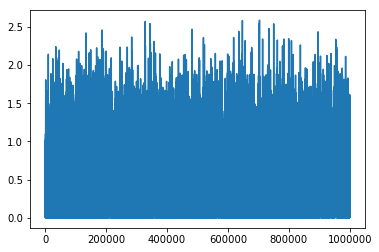

In [123]:
plt.plot(intensity)
print(intensity.mean())
# what should it be
print(N/L)

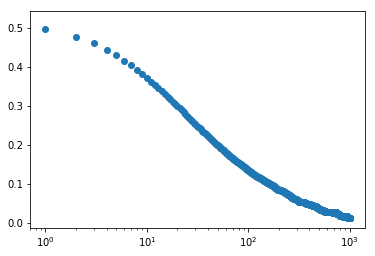

In [138]:
# calculate autocorrelation function
f = np.fft.rfft(intensity)
acf = np.fft.irfft(f * np.conjugate(f))
acf = np.fft.fftshift(acf) / length
autocorr = acf[int(length/2):]/intensity.mean()**2

autocorr = autocorr[:1000]-1.0
t = np.arange(0,autocorr.size)
plt.semilogx(t,autocorr,"o")

In [139]:
print(autocorr[0]/N*L)
print(L/autocorr[0]/N)
print(autocorr[0]*N/L*2*np.sqrt(np.pi))
print(L/autocorr[0]/N/np.sqrt(np.pi))

1.06507853752
3.94571841601
0.898418824675
2.22613322993


In [126]:
# this is the model that describes the ideal case if infinite boundary conditions
def corrfit(s,N,D,gamma,w0):
    return 1/N/(1+(D*dt*s/w0**2))**gamma

In [ ]:
# this is the more realistic model with periodic boundary conditions -L,L
def corrfitPB(s,N,D,w0,L):
    nmax = 20
    n = np.arange(0,nmax)
    efa = n*np.pi*w0**2*1j
    an = np.exp(-n**2*np.pi**2*w0**2/2/L**2)*(sf.erf((L**2-efa)/np.sqrt(2)/L/w0)+sf.erf((L**2+efa)/np.sqrt(2)/L/w0))
    t=s*dt
    

In [131]:
corrfit_model=lm.Model(corrfit)
params = corrfit_model.make_params()
params['w0'].set(value=1,vary=False)
params['N'].set(value=5,vary=True)
params['D'].set(value=1,vary=True)
params['gamma'].set(value=0.5,vary=False)

result = corrfit_model.fit(s=t,data=autocorr,params=params)

In [132]:
print(result.fit_report())

[[Model]]
    Model(corrfit)
[[Fit Statistics]]
    # function evals   = 33
    # data points      = 500
    # variables        = 2
    chi-square         = 0.146
    reduced chi-square = 0.000
    Akaike info crit   = -4064.521
    Bayesian info crit = -4056.091
[[Variables]]
    N:       1.68581279 +/- 0.029943 (1.78%) (init= 5)
    D:       1.01838992 +/- 0.044338 (4.35%) (init= 1)
    gamma:   0.5 (fixed)
    w0:      1 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(N, D)                      = -0.942 



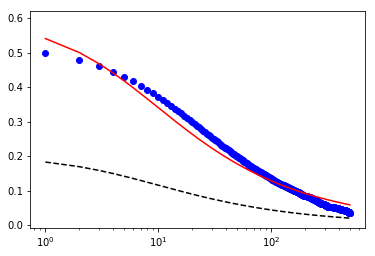

In [133]:
plt.semilogx(t, autocorr,         'bo')
plt.semilogx(t, result.init_fit, 'k--')
plt.semilogx(t, result.best_fit, 'r-')